In [73]:
import os
import numpy as np
import torch
import imageio
import json

from robomimic.utils import file_utils as FileUtils
from robomimic.utils import obs_utils as ObsUtils
from robomimic.utils import env_utils as EnvUtils

from robomimic.envs.env_base import EnvBase
from robomimic.algo import RolloutPolicy
from copy import deepcopy

In [74]:
CKPT_PATH = "../models/model_epoch_1100_low_dim_v15_success_0.7.pth"  # <-- change
OUT_DIR = "video"
os.makedirs(OUT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load checkpoint dict (robomimic-style)
ckpt = torch.load(CKPT_PATH, map_location="cpu")
cfg = ckpt["config"]
cfg = json.loads(cfg)
cfg["observation"]["modalities"]

# Important: init obs modalities exactly as training expected
ObsUtils.initialize_obs_utils_with_obs_specs(cfg["observation"]["modalities"])


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos', 'object']
using obs modality: rgb with keys: []
using obs modality: depth with keys: []
using obs modality: scan with keys: []


In [75]:
env, _ = FileUtils.env_from_checkpoint(
    ckpt_path=CKPT_PATH,
    render=False,
    render_offscreen=True,
)

Created environment with name TwoArmTransport
Action size is 14


In [76]:
policy, _ = FileUtils.policy_from_checkpoint(
    ckpt_path=CKPT_PATH,
    device=device,
    verbose=True,
)


============= Loaded Config =============
{
    "algo_name": "diffusion_policy",
    "experiment": {
        "name": "run_20260122_211123",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": true,
            "log_wandb": true,
            "wandb_proj_name": "guided_diffusion"
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 50,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 100,
        "validation_epoch_every_n_steps": 10,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": false,
        "keep_all_videos": false,
        "video_skip": 20,
        "rollout": {
            "enabled": true,
            "n": 20,
            "horizon": 700,
       

In [78]:
print(type(policy.policy))

<class 'robomimic.algo.diffusion_policy.DiffusionPolicyUNet'>


In [63]:
def rollout(policy, env, horizon, render=False, video_writer=None, video_skip=5, camera_names=None):
    """
    Helper function to carry out rollouts. Supports on-screen rendering, off-screen rendering to a video, 
    and returns the rollout trajectory.
    Args:
        policy (instance of RolloutPolicy): policy loaded from a checkpoint
        env (instance of EnvBase): env loaded from a checkpoint or demonstration metadata
        horizon (int): maximum horizon for the rollout
        render (bool): whether to render rollout on-screen
        video_writer (imageio writer): if provided, use to write rollout to video
        video_skip (int): how often to write video frames
        camera_names (list): determines which camera(s) are used for rendering. Pass more than
            one to output a video with multiple camera views concatenated horizontally.
    Returns:
        stats (dict): some statistics for the rollout - such as return, horizon, and task success
    """
    print("env type:", type(env))

    assert isinstance(policy, RolloutPolicy)
    assert not (render and (video_writer is not None))

    policy.start_episode()
    obs = env.reset()
    state_dict = env.get_state()

    # hack that is necessary for robosuite tasks for deterministic action playback
    obs = env.reset_to(state_dict)

    results = {}
    video_count = 0  # video frame counter
    total_reward = 0.
    
    payload_pos_seq = np.zeros((horizon,3), dtype=np.float32)
    payload_body_seq = np.zeros((horizon,3,3), dtype=np.float32)

    try:
        for step_i in range(horizon):

            print(step_i)
            print(obs.keys())
            # get action from policy
            act = policy(ob=obs)

            # play action
            next_obs, r, done, _ = env.step(act)

            # compute reward
            total_reward += r
            success = env.is_success()["task"]

            sim = env.env.env.sim            
            R = sim.data.body_xmat[bid].reshape(3,3)
            payload_pos_seq[step_i] = sim.data.body_xpos[bid]
            payload_body_seq[step_i] = R


            # visualization
            if render:
                env.render(mode="human", camera_name=camera_names[0])
            if video_writer is not None:
                if video_count % video_skip == 0:
                    video_img = []
                    for cam_name in camera_names:
                        video_img.append(env.render(mode="rgb_array", height=512, width=512, camera_name=cam_name))
                    video_img = np.concatenate(video_img, axis=1) # concatenate horizontally
                    video_writer.append_data(video_img)
                video_count += 1

            # break if done or if success
            if done or success:
                break

            # update for next iter
            obs = deepcopy(next_obs)
            state_dict = env.get_state()

    except env.rollout_exceptions as e:
        print("WARNING: got rollout exception {}".format(e))

    stats = dict(Return=total_reward, Horizon=(step_i + 1), Success_Rate=float(success), Pos_Seq=payload_pos_seq, Upz_Seq=payload_body_seq)

    return stats

In [64]:
rollout_horizon = 500
np.random.seed(0)
torch.manual_seed(0)

In [65]:
video_path = "../videos/rollout.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

stats = rollout(
    policy=policy, 
    env=env, 
    horizon=rollout_horizon, 
    render=False, 
    video_writer=video_writer, 
    video_skip=30, 
    camera_names=["agentview"]
)
print(stats)
video_writer.close()

env type: <class 'robomimic.envs.wrappers.FrameStackWrapper'>
0
dict_keys(['object', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_quat_site', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot1_joint_pos', 'robot1_joint_pos_cos', 'robot1_joint_pos_sin', 'robot1_joint_vel', 'robot1_eef_pos', 'robot1_eef_quat', 'robot1_eef_quat_site', 'robot1_gripper_qpos', 'robot1_gripper_qvel', 'lang_emb', 'timesteps', 'actions'])
1
dict_keys(['object', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_quat_site', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot1_joint_pos', 'robot1_joint_pos_cos', 'robot1_joint_pos_sin', 'robot1_joint_vel', 'robot1_eef_pos', 'robot1_eef_quat', 'robot1_eef_quat_site', 'robot1_gripper_qpos', 'robot1_gripper_qvel', 'lang_emb', 'timesteps', 'actions'])
2
dict_keys(['object', 'robot0_joint_p

In [67]:
from IPython.display import Video
Video(video_path)

[[-9.92421865e-01  1.13615172e-03 -1.22871935e-01]
 [-1.22876488e-01 -5.79830352e-03  9.92405057e-01]
 [ 4.15073970e-04  9.99982536e-01  5.89396944e-03]]


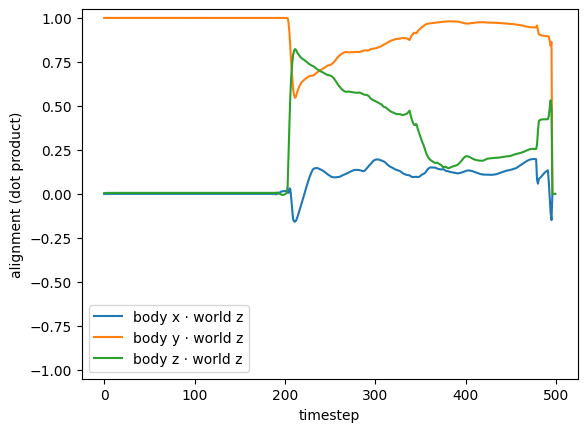

In [71]:
import matplotlib.pyplot as plt

# R_seq: (T, 3, 3) rotation matrices, world_R_body
R_seq = np.asarray(stats['Upz_Seq'])
assert R_seq.shape[1:] == (3, 3), f"Expected (T,3,3), got {R_seq.shape}"

T = R_seq.shape[0]
t = np.arange(T)

# alignment of each body axis with world +z

print(R_seq[10])
dot_x = R_seq[:,2,0]
dot_y = R_seq[:,2,1]
dot_z = R_seq[:,2,2]

plt.figure()
plt.plot(t, dot_x, label="body x · world z")
plt.plot(t, dot_y, label="body y · world z")
plt.plot(t, dot_z, label="body z · world z")
plt.xlabel("timestep")
plt.ylabel("alignment (dot product)")
plt.ylim(-1.05, 1.05)
plt.legend()
plt.show()

In [72]:
t_up = 220    # choose from your video
t_down = 50   # choose from your video

for t in [t_down, t_up]:
    R = R_seq[t]
    print("\n t =", t)
    print("R[2,:] =", R[2,:], "   (world-z components of body x,y,z)")
    print("dot_x, dot_y, dot_z =", R[2,0], R[2,1], R[2,2])


 t = 50
R[2,:] = [4.534330e-04 9.999829e-01 5.829180e-03]    (world-z components of body x,y,z)
dot_x, dot_y, dot_z = 0.000453433 0.9999829 0.00582918

 t = 220
R[2,:] = [-0.02739774  0.6421926   0.76605356]    (world-z components of body x,y,z)
dot_x, dot_y, dot_z = -0.027397737 0.6421926 0.76605356
